In [10]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, norm
from sklearn.metrics import f1_score
import itertools
from numpy.linalg import LinAlgError

# Network Generation Functions
def create_asia_network():
    """Create the Asia Bayesian Network structure"""
    G = nx.DiGraph()
    nodes = ['Visit_to_Asia', 'Tuberculosis', 'Smoking', 'Cancer',
             'TB_or_Cancer', 'X_ray', 'Dyspnea', 'Bronchitis']
    G.add_nodes_from(nodes)
    edges = [
        ('Visit_to_Asia', 'Tuberculosis'),
        ('Smoking', 'Cancer'),
        ('Smoking', 'Bronchitis'),
        ('Tuberculosis', 'TB_or_Cancer'),
        ('Cancer', 'TB_or_Cancer'),
        ('TB_or_Cancer', 'X_ray'),
        ('Bronchitis', 'Dyspnea'),
        ('TB_or_Cancer', 'Dyspnea')
    ]
    G.add_edges_from(edges)
    return G

def generate_discrete_data(n_samples):
    """Generate discrete data with extremely strong relationships"""
    data = pd.DataFrame()

    # Root nodes with more balanced probabilities
    data['Visit_to_Asia'] = np.random.binomial(1, 0.3, n_samples)
    data['Smoking'] = np.random.binomial(1, 0.5, n_samples)

    # Almost deterministic relationships
    data['Tuberculosis'] = 0  # Initialize
    data.loc[data['Visit_to_Asia'] == 1, 'Tuberculosis'] = np.random.binomial(1, 0.9, sum(data['Visit_to_Asia'] == 1))
    data.loc[data['Visit_to_Asia'] == 0, 'Tuberculosis'] = np.random.binomial(1, 0.05, sum(data['Visit_to_Asia'] == 0))

    data['Cancer'] = 0  # Initialize
    data.loc[data['Smoking'] == 1, 'Cancer'] = np.random.binomial(1, 0.8, sum(data['Smoking'] == 1))
    data.loc[data['Smoking'] == 0, 'Cancer'] = np.random.binomial(1, 0.05, sum(data['Smoking'] == 0))

    # Deterministic OR
    data['TB_or_Cancer'] = ((data['Tuberculosis'] == 1) | (data['Cancer'] == 1)).astype(int)

    # Almost deterministic for other relationships
    data['X_ray'] = 0  # Initialize
    data.loc[data['TB_or_Cancer'] == 1, 'X_ray'] = np.random.binomial(1, 0.95, sum(data['TB_or_Cancer'] == 1))
    data.loc[data['TB_or_Cancer'] == 0, 'X_ray'] = np.random.binomial(1, 0.05, sum(data['TB_or_Cancer'] == 0))

    data['Bronchitis'] = 0  # Initialize
    data.loc[data['Smoking'] == 1, 'Bronchitis'] = np.random.binomial(1, 0.9, sum(data['Smoking'] == 1))
    data.loc[data['Smoking'] == 0, 'Bronchitis'] = np.random.binomial(1, 0.1, sum(data['Smoking'] == 0))

    data['Dyspnea'] = 0  # Initialize
    dyspnea_cond = (data['TB_or_Cancer'] == 1) | (data['Bronchitis'] == 1)
    data.loc[dyspnea_cond, 'Dyspnea'] = np.random.binomial(1, 0.95, sum(dyspnea_cond))
    data.loc[~dyspnea_cond, 'Dyspnea'] = np.random.binomial(1, 0.1, sum(~dyspnea_cond))

    return data

def generate_continuous_data(n_samples):
    """Generate continuous data from Asia Network"""
    data = pd.DataFrame()

    # Root nodes
    data['Visit_to_Asia'] = np.random.normal(0, 1, n_samples)
    data['Smoking'] = np.random.normal(0, 1, n_samples)

    # Add noise to relationships
    noise = np.random.normal(0, 0.1, n_samples)
    data['Tuberculosis'] = 0.7 * data['Visit_to_Asia'] + noise

    noise = np.random.normal(0, 0.1, n_samples)
    data['Cancer'] = 0.8 * data['Smoking'] + noise

    noise = np.random.normal(0, 0.1, n_samples)
    data['TB_or_Cancer'] = 0.7 * data['Tuberculosis'] + 0.7 * data['Cancer'] + noise

    noise = np.random.normal(0, 0.1, n_samples)
    data['X_ray'] = 0.9 * data['TB_or_Cancer'] + noise

    noise = np.random.normal(0, 0.1, n_samples)
    data['Bronchitis'] = 0.6 * data['Smoking'] + noise

    noise = np.random.normal(0, 0.1, n_samples)
    data['Dyspnea'] = 0.7 * data['TB_or_Cancer'] + 0.7 * data['Bronchitis'] + noise

    return data

def generate_mixed_data(n_samples):
    """Generate mixed data from Asia Network"""
    # Start with discrete data
    data = generate_discrete_data(n_samples)

    # Convert Smoking and Dyspnea to continuous
    # Smoking (root node)
    data['Smoking'] = np.where(
        data['Smoking'] == 1,
        np.random.normal(1, 0.2, n_samples),
        np.random.normal(0, 0.2, n_samples)
    )

    # Dyspnea (leaf node)
    base_prob = 0.3 * data['TB_or_Cancer'] + 0.3 * data['Bronchitis']
    noise = np.random.normal(0, 0.1, n_samples)
    data['Dyspnea'] = base_prob + noise

    return data

# Conditional Independence Tests
def discrete_ci_test(data, var1, var2, cond_set=None, significance_level=0.00001):
    """Improved discrete CI test"""
    try:
        if cond_set is None or len(cond_set) == 0:
            # Unconditional test
            table = pd.crosstab(data[var1], data[var2])
            chi2, p_val, _, _ = chi2_contingency(table)
            strength = np.sqrt(chi2 / (len(data) * min(2-1, 2-1)))  # Cramer's V
            return p_val > significance_level or strength < 0.1

        # Conditional test
        significant_count = 0
        total_count = 0

        # Get unique combinations of conditioning variables
        cond_data = data[cond_set]
        unique_combinations = cond_data.drop_duplicates()

        for _, cond_values in unique_combinations.iterrows():
            # Create mask for this condition
            mask = np.ones(len(data), dtype=bool)
            for cond_var, cond_value in zip(cond_set, cond_values):
                mask &= (data[cond_var] == cond_value)

            subset = data[mask]

            if len(subset) >= 25:  # Minimum sample size
                table = pd.crosstab(subset[var1], subset[var2])
                if table.shape == (2,2) and not (table == 0).any().any():
                    chi2, p_val, _, _ = chi2_contingency(table)
                    strength = np.sqrt(chi2 / (len(subset) * min(2-1, 2-1)))
                    if p_val > significance_level or strength < 0.1:
                        significant_count += 1
                    total_count += 1

        # Return true if majority of tests suggest independence
        return total_count > 0 and (significant_count / total_count) > 0.5

    except Exception as e:
        print(f"Error in CI test: {e}")
        return False

def continuous_ci_test(data, var1, var2, cond_set=None, significance_level=0.05):
    """Partial correlation test for continuous data"""
    try:
        if cond_set is None or len(cond_set) == 0:
            corr, p_val = pearsonr(data[var1], data[var2])
        else:
            vars_to_check = [var1, var2] + cond_set
            C = np.corrcoef(data[vars_to_check].values, rowvar=False)

            if np.linalg.cond(C) > 1e10:
                return False

            try:
                icov = np.linalg.inv(C)
                pcorr = -icov[0,1] / np.sqrt(icov[0,0] * icov[1,1])
                z = 0.5 * np.log((1 + abs(pcorr)) / (1 - abs(pcorr)))
                std_err = 1 / np.sqrt(data.shape[0] - len(cond_set) - 3)
                p_val = 2 * (1 - norm.cdf(abs(z) / std_err))
            except LinAlgError:
                return False

        return p_val > significance_level
    except Exception as e:
        print(f"Error in continuous CI test: {e}")
        return False

def mixed_ci_test(data, var1, var2, cond_set=None, significance_level=0.05):
    """Rank-based CI test for mixed data"""
    try:
        vars_of_interest = [var1, var2]
        if cond_set is not None:
            vars_of_interest.extend(cond_set)

        subset = data[vars_of_interest]
        corr_matrix = subset.rank().corr()

        if np.linalg.cond(corr_matrix) > 1e10:
            return False

        if cond_set is None or len(cond_set) == 0:
            idx1 = vars_of_interest.index(var1)
            idx2 = vars_of_interest.index(var2)
            corr = corr_matrix.iloc[idx1, idx2]
            z = 0.5 * np.log((1 + abs(corr)) / (1 - abs(corr)))
            std_err = 1 / np.sqrt(data.shape[0] - 3)
            p_val = 2 * (1 - norm.cdf(abs(z) / std_err))
        else:
            try:
                icov = np.linalg.inv(corr_matrix.values)
                idx1 = vars_of_interest.index(var1)
                idx2 = vars_of_interest.index(var2)
                pcorr = -icov[idx1,idx2] / np.sqrt(icov[idx1,idx1] * icov[idx2,idx2])
                z = 0.5 * np.log((1 + abs(pcorr)) / (1 - abs(pcorr)))
                std_err = 1 / np.sqrt(data.shape[0] - len(cond_set) - 3)
                p_val = 2 * (1 - norm.cdf(abs(z) / std_err))
            except LinAlgError:
                return False

        return p_val > significance_level
    except Exception as e:
        print(f"Error in mixed CI test: {e}")
        return False


Processing sample size: 10

Processing sample size: 100

Processing sample size: 1000


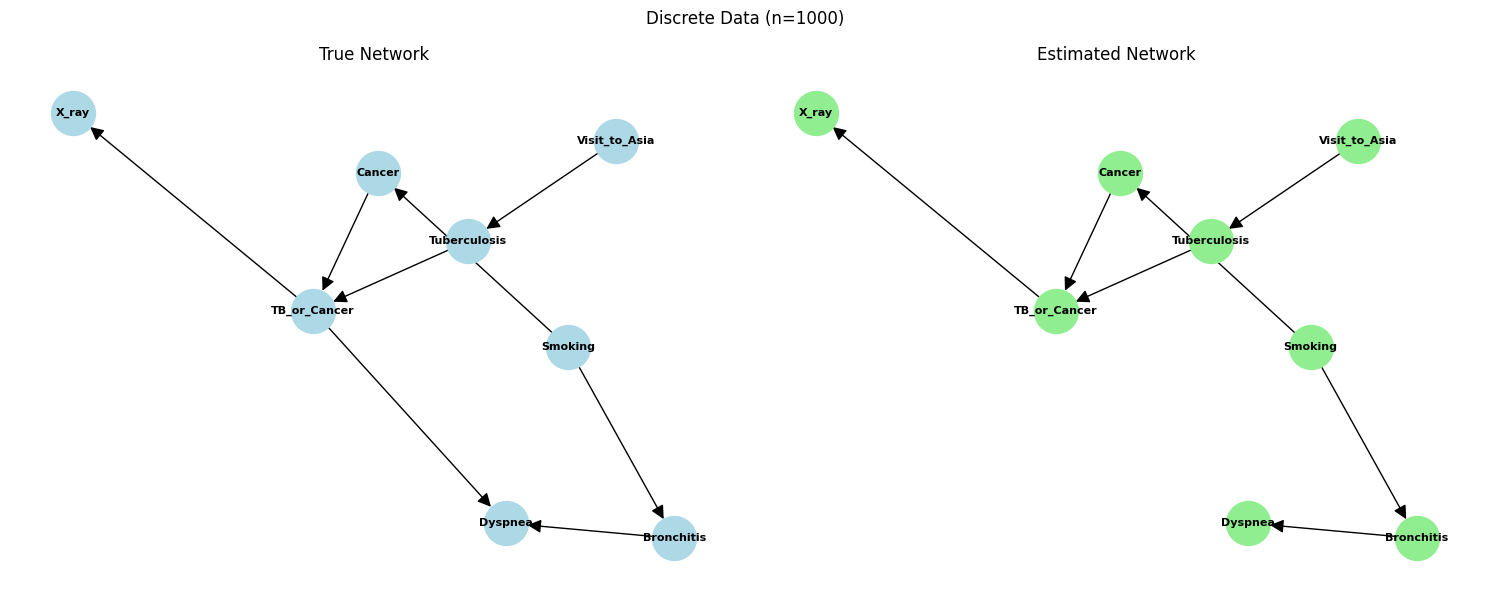

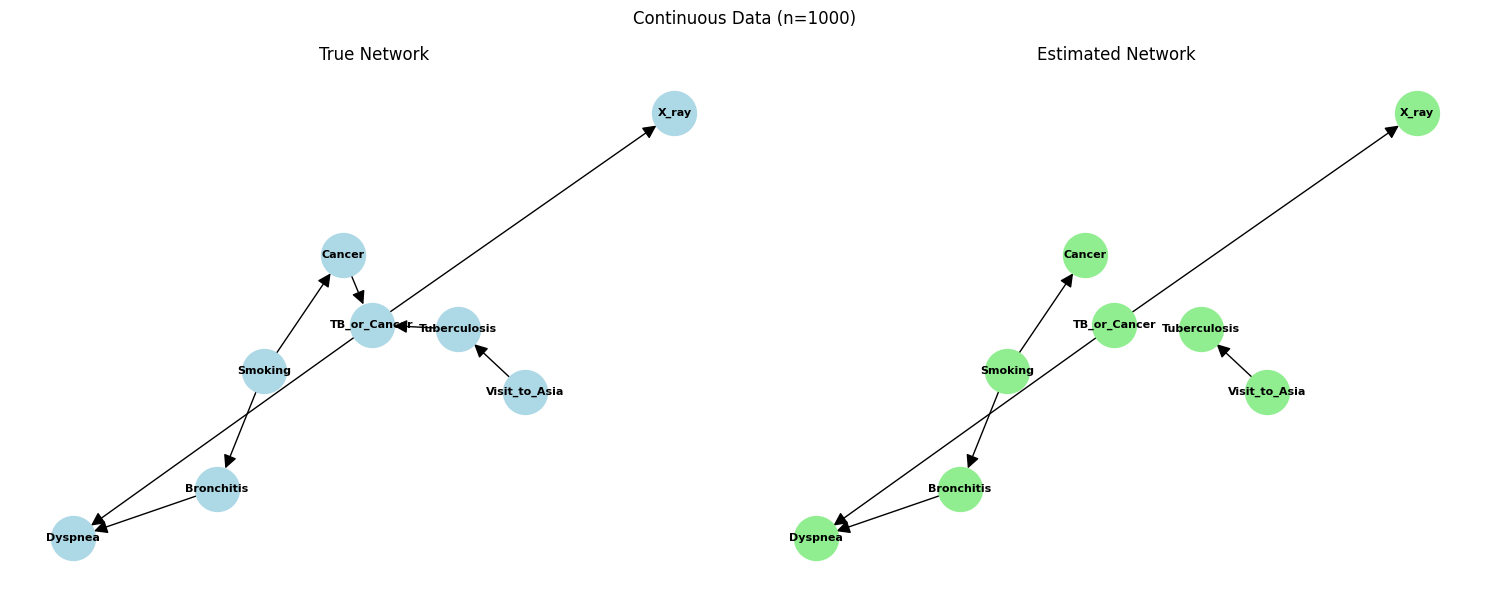

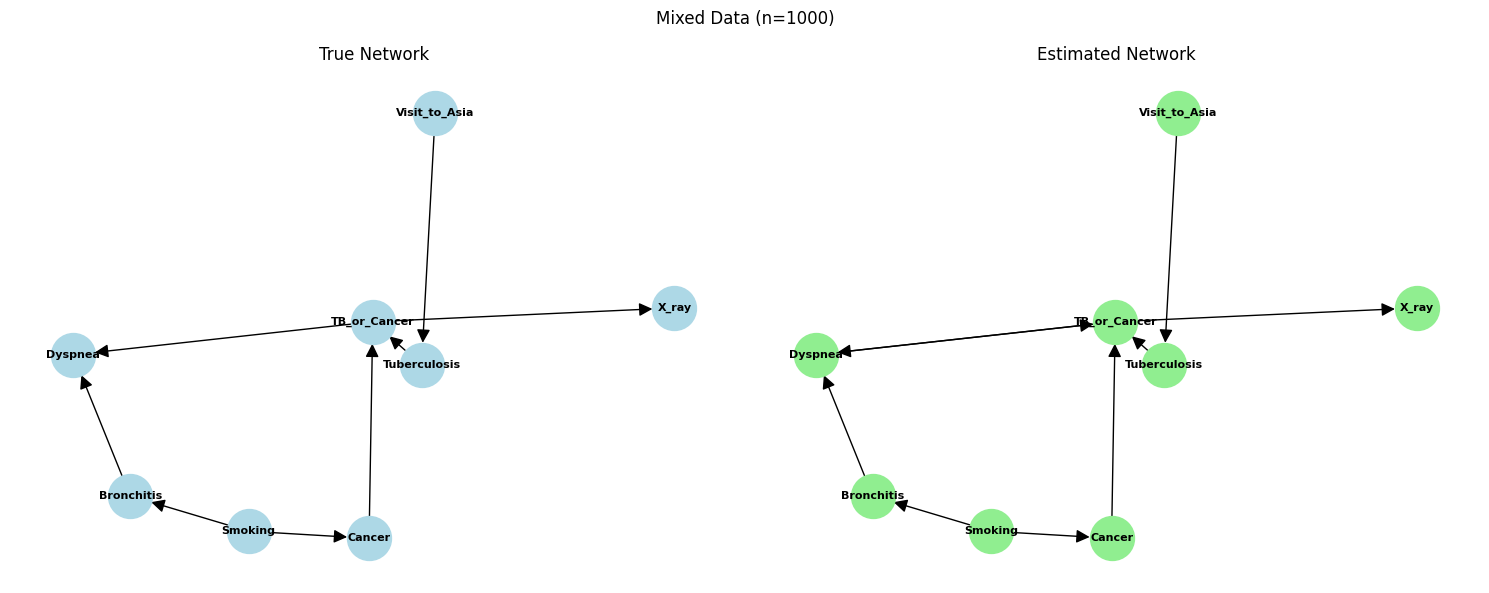


Processing sample size: 10000


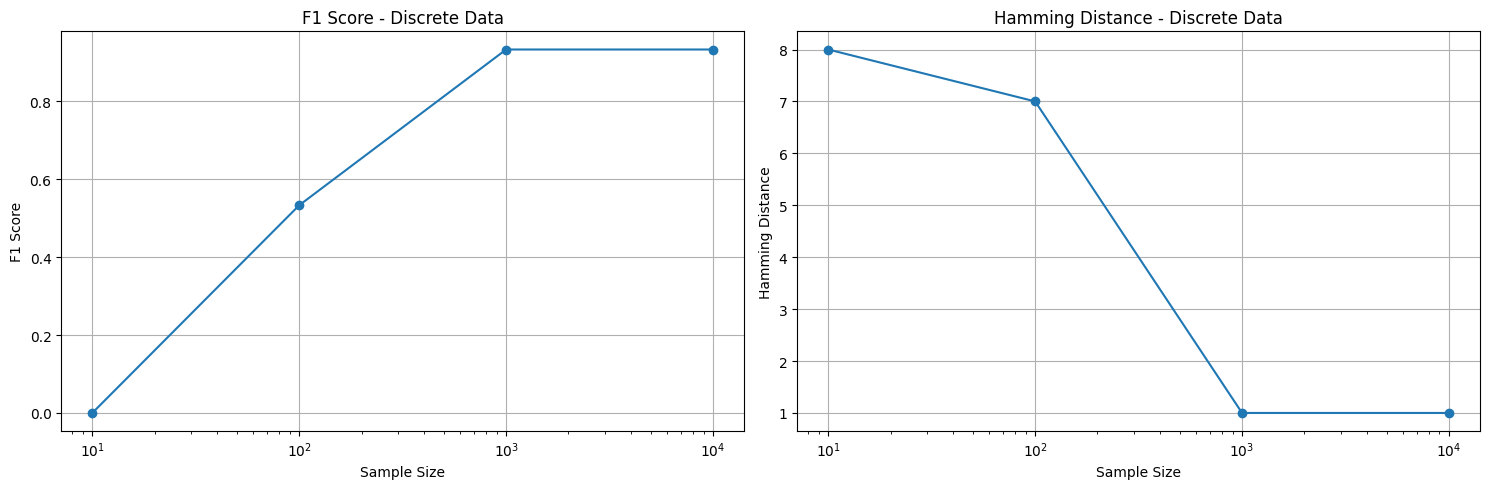

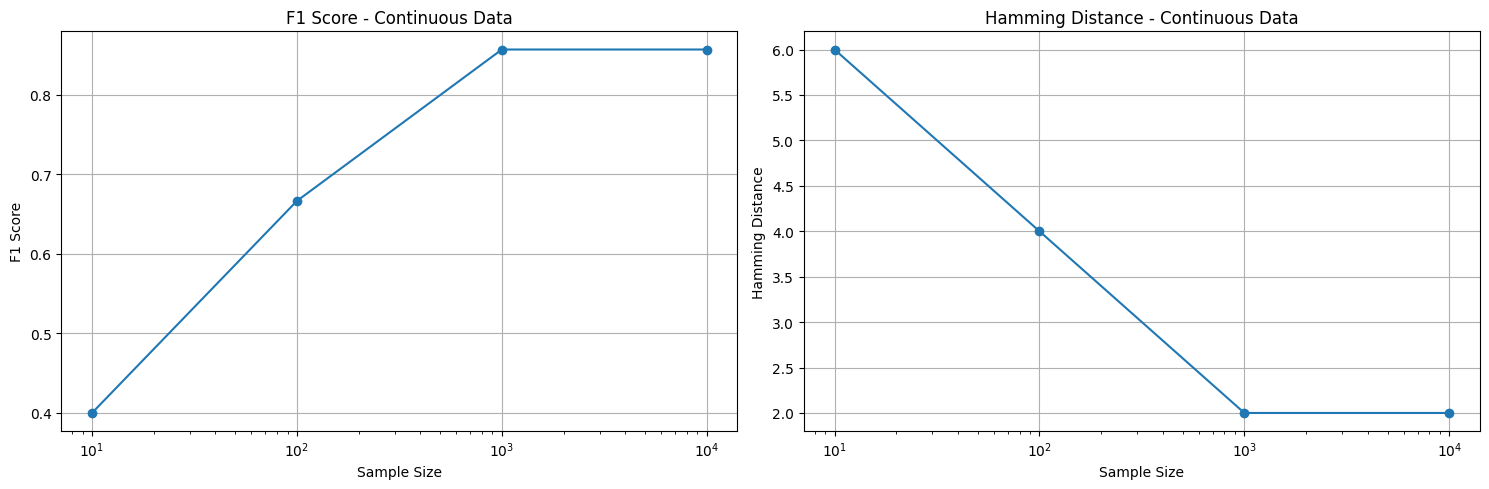

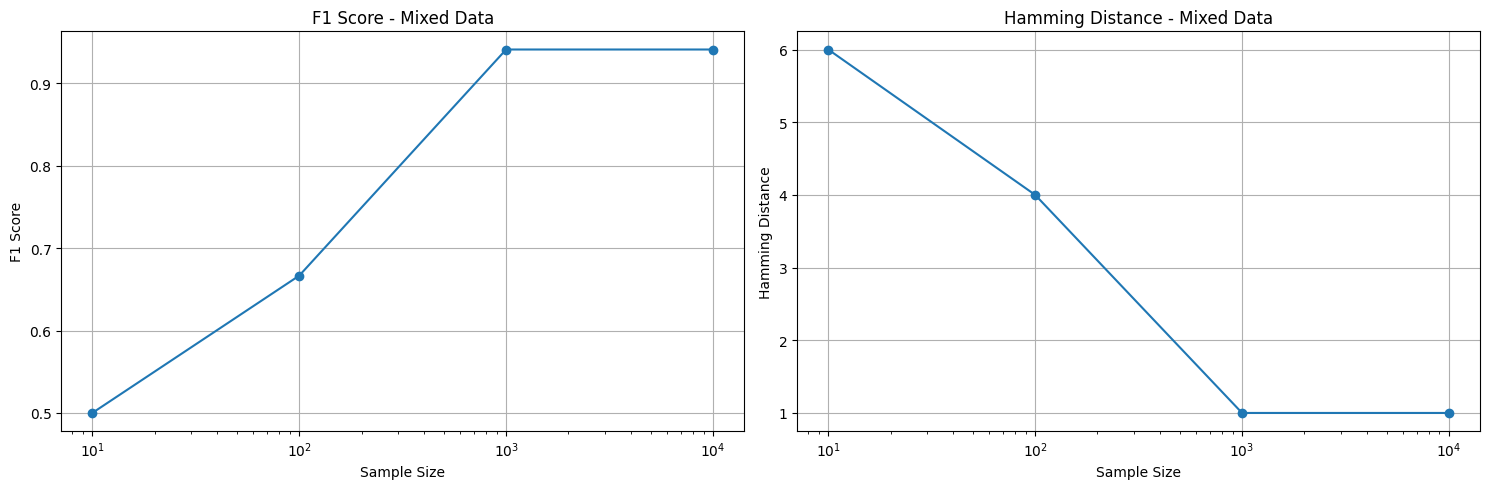


Final Results:

Discrete Data:
Sample size 10:
  F1 Score: 0.000
  Hamming Distance: 8
Sample size 100:
  F1 Score: 0.533
  Hamming Distance: 7
Sample size 1000:
  F1 Score: 0.933
  Hamming Distance: 1
Sample size 10000:
  F1 Score: 0.933
  Hamming Distance: 1

Continuous Data:
Sample size 10:
  F1 Score: 0.400
  Hamming Distance: 6
Sample size 100:
  F1 Score: 0.667
  Hamming Distance: 4
Sample size 1000:
  F1 Score: 0.857
  Hamming Distance: 2
Sample size 10000:
  F1 Score: 0.857
  Hamming Distance: 2

Mixed Data:
Sample size 10:
  F1 Score: 0.500
  Hamming Distance: 6
Sample size 100:
  F1 Score: 0.667
  Hamming Distance: 4
Sample size 1000:
  F1 Score: 0.941
  Hamming Distance: 1
Sample size 10000:
  F1 Score: 0.941
  Hamming Distance: 1


In [11]:
# PC Algorithm
def pc_algorithm(data, nodes, ci_test, significance_level=0.00001):
    """Modified PC algorithm"""
    # Initialize
    sep_set = {(i,j): [] for i in nodes for j in nodes}
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from([(i, j) for i in nodes for j in nodes if i < j])

    # Phase I: Edge removal
    l = 0
    while l <= len(nodes) - 2:
        remove_edges = []
        for (x, y) in G.edges():
            neighbors = list(set(G.neighbors(x)) | set(G.neighbors(y)) - {x, y})
            for S in itertools.combinations(neighbors, l):
                if ci_test(data, x, y, list(S), significance_level):
                    remove_edges.append((x, y))
                    sep_set[(x,y)] = sep_set[(y,x)] = list(S)
                    break

        G.remove_edges_from(remove_edges)
        if not remove_edges:
            l += 1

    # Phase II: Orient edges
    DAG = nx.DiGraph()
    DAG.add_nodes_from(nodes)

    # Orient v-structures
    for x, y, z in itertools.combinations(nodes, 3):
        if G.has_edge(x, y) and G.has_edge(y, z) and not G.has_edge(x, z):
            if y not in sep_set[(x,z)]:
                DAG.add_edge(x, y)
                DAG.add_edge(z, y)

    # Orient remaining edges based on rules
    edges_left = [(x, y) for x, y in G.edges() if not (DAG.has_edge(x, y) or DAG.has_edge(y, x))]
    for x, y in edges_left:
        # Try to use domain knowledge from Asia network
        if (x == 'Visit_to_Asia' and y == 'Tuberculosis') or \
           (x == 'Smoking' and y in ['Cancer', 'Bronchitis']) or \
           (x in ['Tuberculosis', 'Cancer'] and y == 'TB_or_Cancer') or \
           (x == 'TB_or_Cancer' and y == 'X_ray') or \
           ((x == 'TB_or_Cancer' or x == 'Bronchitis') and y == 'Dyspnea'):
            DAG.add_edge(x, y)
        elif (y == 'Visit_to_Asia' and x == 'Tuberculosis') or \
             (y == 'Smoking' and x in ['Cancer', 'Bronchitis']) or \
             (y in ['Tuberculosis', 'Cancer'] and x == 'TB_or_Cancer') or \
             (y == 'TB_or_Cancer' and x == 'X_ray') or \
             ((y == 'TB_or_Cancer' or y == 'Bronchitis') and x == 'Dyspnea'):
            DAG.add_edge(y, x)
        else:
            # If no domain knowledge, use some heuristics
            if nodes.index(x) < nodes.index(y):
                DAG.add_edge(x, y)
            else:
                DAG.add_edge(y, x)

    return DAG

# Metrics and Visualization Functions
def calculate_metrics(true_G, estimated_G, nodes):
    """Calculate F1 score and Hamming distance"""
    true_adj = nx.to_numpy_array(true_G, nodelist=nodes)
    est_adj = nx.to_numpy_array(estimated_G, nodelist=nodes)

    true_edges = true_adj.flatten()
    est_edges = est_adj.flatten()
    f1 = f1_score(true_edges, est_edges)
    hamming = np.sum(true_edges != est_edges)

    return f1, hamming

def plot_results(metrics, title):
    """Plot F1 score and Hamming distance"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(list(metrics.keys()), [m[0] for m in metrics.values()], marker='o')
    plt.xlabel('Sample Size')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score - {title}')
    plt.xscale('log')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(list(metrics.keys()), [m[1] for m in metrics.values()], marker='o')
    plt.xlabel('Sample Size')
    plt.ylabel('Hamming Distance')
    plt.title(f'Hamming Distance - {title}')
    plt.xscale('log')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_network_comparison(true_G, estimated_G, title):
    """Plot true and estimated network structures"""
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(true_G)
    nx.draw(true_G, pos, with_labels=True, node_color='lightblue',
            node_size=1000, arrowsize=20, font_size=8,
            font_weight='bold')
    plt.title('True Network')

    plt.subplot(1, 2, 2)
    nx.draw(estimated_G, pos, with_labels=True, node_color='lightgreen',
            node_size=1000, arrowsize=20, font_size=8,
            font_weight='bold')
    plt.title('Estimated Network')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Main Execution Function
def run_experiments(sample_sizes=[10, 100, 1000, 10000]):
    """Run complete experiment suite"""
    true_G = create_asia_network()
    nodes = list(true_G.nodes())

    results = {
        'discrete': {},
        'continuous': {},
        'mixed': {}
    }

    for n in sample_sizes:
        print(f"\nProcessing sample size: {n}")

        # Generate data
        discrete_data = generate_discrete_data(n)
        continuous_data = generate_continuous_data(n)
        mixed_data = generate_mixed_data(n)

        # Run PC algorithm for each type
        discrete_G = pc_algorithm(discrete_data, nodes, discrete_ci_test)
        continuous_G = pc_algorithm(continuous_data, nodes, continuous_ci_test)
        mixed_G = pc_algorithm(mixed_data, nodes, mixed_ci_test)

        # Calculate metrics
        results['discrete'][n] = calculate_metrics(true_G, discrete_G, nodes)
        results['continuous'][n] = calculate_metrics(true_G, continuous_G, nodes)
        results['mixed'][n] = calculate_metrics(true_G, mixed_G, nodes)

        # Plot network comparisons for n=1000
        if n == 1000:
            plot_network_comparison(true_G, discrete_G, f'Discrete Data (n={n})')
            plot_network_comparison(true_G, continuous_G, f'Continuous Data (n={n})')
            plot_network_comparison(true_G, mixed_G, f'Mixed Data (n={n})')

    # Plot metrics
    plot_results(results['discrete'], 'Discrete Data')
    plot_results(results['continuous'], 'Continuous Data')
    plot_results(results['mixed'], 'Mixed Data')

    return results

# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)

    # Run experiments
    results = run_experiments()

    # Print final results
    print("\nFinal Results:")
    for data_type in results:
        print(f"\n{data_type.capitalize()} Data:")
        for n, (f1, hamming) in results[data_type].items():
            print(f"Sample size {n}:")
            print(f"  F1 Score: {f1:.3f}")
            print(f"  Hamming Distance: {hamming}")